In [1]:
from transformers import (
    T5ForConditionalGeneration,
    MT5ForConditionalGeneration,
    T5Tokenizer
)

import argparse
import pandas as pd
import sys
import os
sys.path.append("../")
from utils import currentdate, QAG_TAG, QG_TAG, AE_TAG

from model.model_qag import QAGModel
from utils import currentdate
import time
import json
import torch

def generate(args, device, qgmodel: QAGModel, tokenizer: T5Tokenizer,  context: str) -> str:

    source_encoding = tokenizer(
        context,
        max_length=args.max_len_input,
        padding='max_length',
        truncation = 'only_second',
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )

    input_ids = source_encoding['input_ids'].to(device)
    attention_mask = source_encoding['attention_mask'].to(device)

    generated_ids = qgmodel.model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        num_return_sequences=args.num_return_sequences,
        num_beams=args.num_beams, 
        max_length=args.max_len_output,
        repetition_penalty=args.repetition_penalty,
        length_penalty=args.length_penalty,
        early_stopping=True,
        use_cache=True
    )

    preds = {
        tokenizer.decode(generated_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for generated_id in generated_ids
    }
    
    return '<DIV>'.join(preds)



/root/.pyenv/versions/3.9.9/envs/capstone/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
params_dict = dict(
    checkpoint_model_path = "../../checkpoints/qag/model-epoch=01-val_loss=1.14.ckpt",
    model_name = "google/mt5-base",
    tokenizer_name = "google/mt5-base",
    max_len_input = 512,
    max_len_output = 96,
    num_beams = 5,
    num_return_sequences = 5,
    repetition_penalty = 1.0,
    length_penalty = 1.0,
)
params = argparse.Namespace(**params_dict)

t5_tokenizer = T5Tokenizer.from_pretrained(params.tokenizer_name)
if "mt5" in params.model_name:
    t5_model = MT5ForConditionalGeneration.from_pretrained(params.model_name)
else:
    t5_model = T5ForConditionalGeneration.from_pretrained(params.model_name)

checkpoint_model_path = params.checkpoint_model_path
qgmodel = QAGModel.load_from_checkpoint(checkpoint_model_path, hparams=params, t5model=t5_model, t5tokenizer=t5_tokenizer)

qgmodel.freeze()
qgmodel.eval()

# Put model in gpu (if possible) or cpu (if not possible) for inference purpose
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qgmodel = qgmodel.to(device)
print ("Device for inference:", device)

Device for inference: cuda


In [37]:
df_test = pd.read_pickle("../../data/squad_vi/raw/dataframe/df_test_en.pkl")

In [7]:
df_train = pd.read_pickle("../../data/squad_vi/raw/dataframe/df_train_en.pkl")
df_val = pd.read_pickle("../../data/squad_vi/raw/dataframe/df_validation_en.pkl")

In [6]:
df_train.shape

(104256, 3)

In [5]:
df_test.shape

(26063, 3)

In [9]:
df_val.shape

(11873, 3)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
!pip install matplotlib

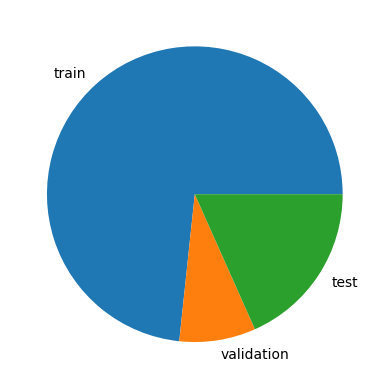

In [14]:
import matplotlib.pyplot as plt
import numpy as np

n_train = df_train.shape[0]
n_val = df_val.shape[0]
n_test = df_test.shape[0]
n_dataset = n_train + n_val + n_test

p_train = n_train / n_dataset * 100
p_val = n_val / n_dataset * 100
p_test = n_test / n_dataset * 100

y = np.array([p_train, p_val, p_test])
mylabels = ["Training data", "Validation data", "Test data"]
plt.pie(y, labels = mylabels)
plt.title("Data training needs")
plt.show()

### Config Tokenizer

In [ ]:
# Customize tokenizer behavior for Vietnamese
t5_tokenizer.do_lower_case = True  # Set to True if you want lowercase tokens
t5_tokenizer.remove_space = True  # Set to True if you want to remove leading/trailing spaces

## BELU

In [ ]:
!pip install nltk
!pip install rouge-metric

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.metrics.scores import (precision, recall)

In [ ]:
smoothie = SmoothingFunction().method4
# https://github.com/nltk/nltk/issues/2217

In [ ]:
i = 1
context_ref = df_test.loc[i]["context"]
answer_ref = df_test.loc[i]["answer"]
question_ref = df_test.loc[i]["question"]

In [ ]:
print(context_ref)
print(answer_ref)
print(question_ref)

In [ ]:
source_text = f"{QG_TAG} answer: {answer_ref} context: {context_ref}"

In [ ]:
custom_config = params_dict.copy()
custom_config["num_return_sequences"] = 1
custom_config = argparse.Namespace(**custom_config)

In [ ]:
question_predicted = generate(custom_config, device, qgmodel, t5_tokenizer, source_text)

In [ ]:
question_predicted

In [ ]:
references = t5_tokenizer.encode(question_ref)
references = t5_tokenizer.convert_ids_to_tokens(references)
candidates = t5_tokenizer.encode(question_predicted)
candidates = t5_tokenizer.convert_ids_to_tokens(candidates)

In [ ]:
references

In [ ]:
candidates

In [ ]:
score = corpus_bleu([references], [candidates], weights=(1, 0, 0, 0))
score

## Eval QG

In [3]:
custom_config = params_dict.copy()
custom_config["num_return_sequences"] = 1
custom_config = argparse.Namespace(**custom_config)

In [ ]:
df_test.shape

In [40]:
import pickle
start_idx = 0
n = df_test.shape[0]
# n = 42
data_test = []
c = 0
generated_questions = []

# Load the existing data from the pickle file, if it exists
try:
    with open('./generated_data.pkl', 'rb') as f:
        generated_data = pickle.load(f)
        generated_questions = [row[3] for row in generated_data]
        start_idx = len(generated_data)
except FileNotFoundError:
    generated_data = []

for i in range(start_idx, n):
    context_ref = df_test.loc[i]["context"]
    answer_ref = df_test.loc[i]["answer"]
    question_ref = df_test.loc[i]["question"]

    source_text = f"{QG_TAG} answer: {answer_ref} context: {context_ref}"
    question_predicted = generate(custom_config, device, qgmodel, t5_tokenizer, source_text)
    data_test.append([context_ref, answer_ref, question_ref, question_predicted])
    generated_questions.append(question_predicted)
    c += 1
    if c >= 10:
        # Append the newly generated data to the existing data
        generated_data.extend(data_test)
        data_test = []

        # Save the updated data to the pickle file
        with open('generated_data.pkl', 'wb') as f:
            pickle.dump(generated_data, f)
        c = 0
    print(f"Generated question i-th = {i}")
# Append the remaining data to the existing data
generated_data.extend(data_test)

# Save the final set of generated data to the pickle file
with open('generated_data.pkl', 'wb') as f:
    pickle.dump(generated_data, f)

## Eval AE

In [35]:
custom_config = params_dict.copy()
custom_config["num_return_sequences"] = 1
custom_config = argparse.Namespace(**custom_config)

In [38]:
import pickle
start_idx = 0
# n = df_test.shape[0]
n = 100
data_test = []
c = 0
generated_answers = []

# Load the existing data from the pickle file, if it exists
try:
    with open('./ae_generated_data.pkl', 'rb') as f:
        generated_data = pickle.load(f)
        generated_answers = [row[3] for row in generated_data]
        start_idx = len(generated_data)
except FileNotFoundError:
    generated_data = []

for i in range(start_idx, n):
    context_ref = df_test.loc[i]["context"]
    answer_ref = df_test.loc[i]["answer"]
    question_ref = df_test.loc[i]["question"]

    source_text = f"{AE_TAG} context: {context_ref}"
    answer_predicted = generate(custom_config, device, qgmodel, t5_tokenizer, source_text)
    data_test.append([context_ref, answer_ref, question_ref, answer_predicted])
    generated_answers.append(answer_predicted)
    c += 1
    if c >= 10:
        # Append the newly generated data to the existing data
        generated_data.extend(data_test)
        data_test = []

        # Save the updated data to the pickle file
        with open('ae_generated_data.pkl', 'wb') as f:
            pickle.dump(generated_data, f)
        c = 0
    print(f"Generated answer i-th = {i}")
# Append the remaining data to the existing data
generated_data.extend(data_test)

# Save the final set of generated data to the pickle file
with open('ae_generated_data.pkl', 'wb') as f:
    pickle.dump(generated_data, f)

Generated answer i-th = 0
Generated answer i-th = 1
Generated answer i-th = 2
Generated answer i-th = 3
Generated answer i-th = 4
Generated answer i-th = 5
Generated answer i-th = 6
Generated answer i-th = 7
Generated answer i-th = 8
Generated answer i-th = 9
Generated answer i-th = 10
Generated answer i-th = 11
Generated answer i-th = 12
Generated answer i-th = 13
Generated answer i-th = 14
Generated answer i-th = 15
Generated answer i-th = 16
Generated answer i-th = 17
Generated answer i-th = 18
Generated answer i-th = 19
Generated answer i-th = 20
Generated answer i-th = 21
Generated answer i-th = 22
Generated answer i-th = 23
Generated answer i-th = 24
Generated answer i-th = 25
Generated answer i-th = 26
Generated answer i-th = 27
Generated answer i-th = 28
Generated answer i-th = 29
Generated answer i-th = 30
Generated answer i-th = 31
Generated answer i-th = 32
Generated answer i-th = 33
Generated answer i-th = 34
Generated answer i-th = 35
Generated answer i-th = 36
Generated a

In [45]:
df_predict = pd.read_pickle("./ae_generated_data.pkl")
df_predict = pd.DataFrame(df_predict, columns=["context_ref", "answer_ref", "question_ref", "answer_predicted"])
df_predict

,context_ref,answer_ref,question_ref,answer_predicted
0,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Vào cuối những năm 1990,Beyonce bắt đầu nổi tiếng từ khi nào?,"""Crazy in Love"""
1,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Hát và nhảy múa,Beyonce đã cạnh tranh trong lĩnh vực nào khi c...,"""Crazy in Love"""
2,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,2003,Beyonce rời Destiny's Child và trở thành ca sĩ...,"""Crazy in Love"""
3,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Houston Khách sạn,Beyonce lớn lên ở thành phố và tiểu bang nào?,"""Crazy in Love"""
4,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Cuối những năm 1990,Beyonce nổi tiếng trong thập kỷ nào?,"""Crazy in Love"""
...,...,...,...,...
95,LeToya Luckett và Roberson trở nên không hài l...,Farrah Franklin và Michelle Williams.,Ai thay thế Luckett và Roberson trong Destiny'...,Bạn trai lâu năm
96,LeToya Luckett và Roberson trở nên không hài l...,Beyoncé,Ai bị đổ lỗi vì Luckett và Roberson bỏ Destiny...,Bạn trai lâu năm
97,LeToya Luckett và Roberson trở nên không hài l...,Mẹ cô ấy,Ai đã giúp Beyoncé vượt qua chứng trầm cảm của...,Bạn trai lâu năm
98,LeToya Luckett và Roberson trở nên không hài l...,Chi Chi Medina,Thành viên mới nhất nào đã bị xoá khỏi Destiny...,Bạn trai lâu năm


### Run test

In [9]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [4]:
df_predict = pd.read_pickle("./generated_data.pkl")
df_predict = pd.DataFrame(df_predict, columns=["context_ref", "answer_ref", "question_ref", "question_predicted"])
df_predict

,context_ref,answer_ref,question_ref,question_predicted
0,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Vào cuối những năm 1990,Beyonce bắt đầu nổi tiếng từ khi nào?,Năm nào thì giselle knowles-carter nổi tiếng?
1,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Hát và nhảy múa,Beyonce đã cạnh tranh trong lĩnh vực nào khi c...,Nữ diễn viên của nhóm nhạc nữ bán chạy nhất th...
2,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,2003,Beyonce rời Destiny's Child và trở thành ca sĩ...,Album đầu tay của cô ấy được phát hành khi nào?
3,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Houston Khách sạn,Beyonce lớn lên ở thành phố và tiểu bang nào?,Giselle Knowles-Carter lớn lên ở đâu?
4,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Cuối những năm 1990,Beyonce nổi tiếng trong thập kỷ nào?,Năm nào biểu diễn chính của nhóm nhạc nữ r & b...
...,...,...,...,...
26058,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,Hạt ngũ cốc,Sản xuất nào mà chính sách nông nghiệp ưu tiên...,Chính sách nông nghiệp ủng hộ sản xuất gì?
26059,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,,Chuyện gì xảy ra năm 1944?,Điều gì đã cắt đứt đường sống của các thành ph...
26060,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,,Chuyện gì đã xảy ra vào năm 1956?,Điều gì đã cắt đứt đường sống của các thành ph...
26061,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,,Chuyện gì xảy ra từ 1955-1977?,Điều gì đã cắt đứt đường sống của các thành ph...


In [5]:
df_predict.shape

(26063, 4)

In [6]:
df_predict = pd.DataFrame(df_predict, columns = ["context_ref", "answer_ref", "question_ref", "question_predicted"])
df_predict

,context_ref,answer_ref,question_ref,question_predicted
0,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Vào cuối những năm 1990,Beyonce bắt đầu nổi tiếng từ khi nào?,Năm nào thì giselle knowles-carter nổi tiếng?
1,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Hát và nhảy múa,Beyonce đã cạnh tranh trong lĩnh vực nào khi c...,Nữ diễn viên của nhóm nhạc nữ bán chạy nhất th...
2,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,2003,Beyonce rời Destiny's Child và trở thành ca sĩ...,Album đầu tay của cô ấy được phát hành khi nào?
3,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Houston Khách sạn,Beyonce lớn lên ở thành phố và tiểu bang nào?,Giselle Knowles-Carter lớn lên ở đâu?
4,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Cuối những năm 1990,Beyonce nổi tiếng trong thập kỷ nào?,Năm nào biểu diễn chính của nhóm nhạc nữ r & b...
...,...,...,...,...
26058,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,Hạt ngũ cốc,Sản xuất nào mà chính sách nông nghiệp ưu tiên...,Chính sách nông nghiệp ủng hộ sản xuất gì?
26059,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,,Chuyện gì xảy ra năm 1944?,Điều gì đã cắt đứt đường sống của các thành ph...
26060,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,,Chuyện gì đã xảy ra vào năm 1956?,Điều gì đã cắt đứt đường sống của các thành ph...
26061,Sau khi Cộng hoà Nhân dân Trung Hoa nắm quyền ...,,Chuyện gì xảy ra từ 1955-1977?,Điều gì đã cắt đứt đường sống của các thành ph...


In [7]:
references_str = df_predict["question_ref"].to_list()
candidates_str = df_predict["question_predicted"].to_list()
references = [] # list of list tokens
candidates = [] # list of list tokens
start_idx = 0
n = 100
for i in range(start_idx, n):
    ref_ids = t5_tokenizer.encode(references_str[i])
    ref_tokens = t5_tokenizer.convert_ids_to_tokens(ref_ids)
    references.append(ref_tokens)

    can_ids = t5_tokenizer.encode(candidates_str[i])
    can_tokens = t5_tokenizer.convert_ids_to_tokens(can_ids)
    candidates.append(can_tokens)
    print("tokenized i-th = " + str(i))

tokenized i-th = 0
tokenized i-th = 1
tokenized i-th = 2
tokenized i-th = 3
tokenized i-th = 4
tokenized i-th = 5
tokenized i-th = 6
tokenized i-th = 7
tokenized i-th = 8
tokenized i-th = 9
tokenized i-th = 10
tokenized i-th = 11
tokenized i-th = 12
tokenized i-th = 13
tokenized i-th = 14
tokenized i-th = 15
tokenized i-th = 16
tokenized i-th = 17
tokenized i-th = 18
tokenized i-th = 19
tokenized i-th = 20
tokenized i-th = 21
tokenized i-th = 22
tokenized i-th = 23
tokenized i-th = 24
tokenized i-th = 25
tokenized i-th = 26
tokenized i-th = 27
tokenized i-th = 28
tokenized i-th = 29
tokenized i-th = 30
tokenized i-th = 31
tokenized i-th = 32
tokenized i-th = 33
tokenized i-th = 34
tokenized i-th = 35
tokenized i-th = 36
tokenized i-th = 37
tokenized i-th = 38
tokenized i-th = 39
tokenized i-th = 40
tokenized i-th = 41
tokenized i-th = 42
tokenized i-th = 43
tokenized i-th = 44
tokenized i-th = 45
tokenized i-th = 46
tokenized i-th = 47
tokenized i-th = 48
tokenized i-th = 49
tokenized 

In [27]:
smoothie = SmoothingFunction().method4

In [32]:
bleu1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=smoothie)
bleu1 * 100

23.301375573155482

In [33]:
bleu2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
bleu2 * 100

5.231222308507492

In [29]:
bleu3 = corpus_bleu(references, candidates, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smoothie)
bleu3 * 100

0.9894012764400619

In [31]:
bleu4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
bleu4 * 100

0.36606045067122717

In [ ]:
from rouge_metric import PyRouge

In [ ]:
rouge = PyRouge(rouge_n=(1), rouge_l=True, rouge_w=False, rouge_s=False, rouge_su=False)

In [ ]:
score2 = rouge.evaluate_tokenized(candidates, references)
score2

In [ ]:
score = 0.22477793361383822
score2 = 0.8104629866682204

In [ ]:
2 * score * score2 / (score + score2) * 100

In [12]:
# Calculate recall and F1 score
true_positives = sum(1 for reference, candidate in zip(references, candidates) if reference == candidate)
false_negatives = len(references) - true_positives
false_positives = len(candidates) - true_positives

recall = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
f1 = 2 * (precision * recall) / (precision + recall)

In [13]:
recall

0.01

In [14]:
precision

0.01

In [15]:
f1

0.01

In [46]:
df_predict = pd.read_pickle("./ae_generated_data.pkl")
df_predict = pd.DataFrame(df_predict, columns=["context_ref", "answer_ref", "question_ref", "answer_predicted"])
df_predict

,context_ref,answer_ref,question_ref,answer_predicted
0,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Vào cuối những năm 1990,Beyonce bắt đầu nổi tiếng từ khi nào?,"""Crazy in Love"""
1,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Hát và nhảy múa,Beyonce đã cạnh tranh trong lĩnh vực nào khi c...,"""Crazy in Love"""
2,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,2003,Beyonce rời Destiny's Child và trở thành ca sĩ...,"""Crazy in Love"""
3,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Houston Khách sạn,Beyonce lớn lên ở thành phố và tiểu bang nào?,"""Crazy in Love"""
4,Beyoncé Giselle Knowles-Carter (/ b i gì ɒ n s...,Cuối những năm 1990,Beyonce nổi tiếng trong thập kỷ nào?,"""Crazy in Love"""
...,...,...,...,...
95,LeToya Luckett và Roberson trở nên không hài l...,Farrah Franklin và Michelle Williams.,Ai thay thế Luckett và Roberson trong Destiny'...,Bạn trai lâu năm
96,LeToya Luckett và Roberson trở nên không hài l...,Beyoncé,Ai bị đổ lỗi vì Luckett và Roberson bỏ Destiny...,Bạn trai lâu năm
97,LeToya Luckett và Roberson trở nên không hài l...,Mẹ cô ấy,Ai đã giúp Beyoncé vượt qua chứng trầm cảm của...,Bạn trai lâu năm
98,LeToya Luckett và Roberson trở nên không hài l...,Chi Chi Medina,Thành viên mới nhất nào đã bị xoá khỏi Destiny...,Bạn trai lâu năm
